In [228]:
import scipy.stats as stats
import numpy as np
import math
from scipy.stats import norm
from scipy.stats import gamma

n=50

true_beta = np.transpose(stats.norm.rvs(loc=0,scale=1,size=2))
true_phi = stats.gamma.rvs(a=3,scale=1/2,size=1)

x = np.transpose(np.array([np.ones(n),stats.norm.rvs(loc=0,scale=1,size=n)]))
y = np.random.normal(x.dot(true_beta), np.sqrt(1/true_phi))


beta0 = stats.norm.rvs(loc=0,scale=1,size=2)
phi0 = stats.gamma.rvs(a=3,scale=1/2,size=1)
theta0 = np.hstack([beta0, phi0])

#Set hyperparameters
a = 3.0
b= 2.0

print(true_beta,true_phi)
print(theta0)
print(x.shape)
print(y.shape)
print(beta0.shape)

[-0.66571738  0.68830884] [ 2.19167731]
[ 1.22156209 -1.3060355   0.89817466]
(50, 2)
(50,)
(2,)


In [229]:
import warnings
warnings.filterwarnings("ignore")

In [230]:
def leapfrog(y,x,theta, r, eps):
    n = y.shape[0]
    #gradients = np.hstack([theta[2]*(sum(np.transpose(x).dot(y))-theta[0:2]*sum(np.transpose(x).dot(x)))-theta[0:2],(.5*n+a-1)/theta[2]-b-.5*sum((y-x.dot(theta[0:2]))*(y-x.dot(theta[0:2])))])
    gradients = np.hstack([theta[2]*(np.transpose(y).dot(x)-np.transpose(x).dot(x).dot(theta[0:2]))-.01*theta[0:2],(.5*n+a-1)/theta[2]-b-0.5*np.transpose((y-x.dot(theta[0:2]))).dot(y-x.dot(theta[0:2]))])
    r_upd = r + eps/2 * (gradients)
    theta_upd = theta + eps * r_upd
    gradients = np.hstack([theta_upd[2]*(np.transpose(y).dot(x)-np.transpose(x).dot(x).dot(theta_upd[0:2]))-.01*theta_upd[0:2],(.5*n+a-1)/theta[2]-b-0.5*np.transpose((y-x.dot(theta_upd[0:2]))).dot(y-x.dot(theta_upd[0:2]))])
    r_upd = r_upd + eps/2 * (gradients)
    return theta_upd, r_upd

In [231]:
def log_joint(y, x, theta): 
    n = y.shape[0]
    return sum(norm.logpdf(y,loc=x.dot(theta[0:2]), scale=1/np.sqrt(theta[2])))+norm.logpdf(theta[0],loc=0,scale=1/np.sqrt(.01))+norm.logpdf(theta[1],loc=0,scale=1/np.sqrt(.01)) +gamma.logpdf(theta[2], a, scale=1/b)
 

In [232]:
def hamilt_mc(theta0, y,x, eps, L, M):
    theta_m = np.zeros((M,3))
    theta_m[0,:] = theta0
    accept_b = 0
    accept_p = 0
    for m in range(1,M):
        r0 = stats.norm.rvs(size=3)
        theta_m[m,:] = theta_m[m-1,:]
        theta_tilde = theta_m[m-1,:]
        r_tilde = r0
        for i in range(L):
            theta_tilde, r_tilde = leapfrog(y,x,theta_tilde, r_tilde, eps) 
        if theta_tilde[2] < 0.0:
            print("reject")
            theta_tilde[2] = theta_m[m-1,2]
        alpha = min(1, np.exp(log_joint(y,x,theta_tilde)-(1/2)*r_tilde.dot(r_tilde))/np.exp(log_joint(y,x,theta_m[m-1,:])-1/2*r0.dot(r0)))
        u = np.random.uniform()
        if alpha > u:
            theta_m[m,:] = theta_tilde
            r_m =-r_tilde #confused why you save this each time since the algorithm has you repropose an r0 each iteration
    return(theta_m)

In [242]:
M = 10000
eps = .001
L= 10


In [243]:
%%time
results,acc_b,acc_p = hamilt_mc(theta0, y,x, eps, L, M)
print("truth", (true_beta, true_phi))
beta0_found = np.mean(results[round(4*M/5):(M-1),0])
beta1_found = np.mean(results[round(4*M/5):(M-1),1])
phi_found = np.mean(results[round(4*M/5):(M-1),2])
print("Mean after burn in we find",beta0_found,beta1_found ,phi_found)
print("acceptance (beta then phi)", acc_b/M, acc_p/M)

truth (array([-0.66571738,  0.68830884]), array([ 2.19167731]))
Mean after burn in we find -0.624446320962 0.700711221749 2.53974011896
acceptance (beta then phi) 0.9999 0.9999
CPU times: user 14.4 s, sys: 15.4 ms, total: 14.5 s
Wall time: 14.5 s


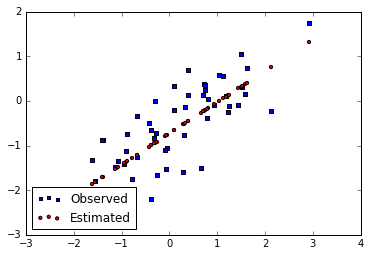

In [244]:
import matplotlib.pyplot as plt
%matplotlib inline
betas_found = np.hstack([beta0_found,beta1_found])
y_sim = stats.norm.rvs(loc=x.dot(betas_found),scale=1/np.sqrt(phi_found))
#y_sim = stats.norm.rvs(loc=x*beta_found,scale=phi_found)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x[:,1], y, s=10, c='b', marker="s", label='Observed')
ax1.scatter(x[:,1], y_sim, s=10, c='r', marker="o", label='Estimated')
plt.legend(loc='lower left');
plt.show()

In [100]:
betas = stats.norm.rvs(true_beta, np.sqrt(1), size=1000)
phis = stats.gamma.rvs(a=3,scale=1/2,size=1000)

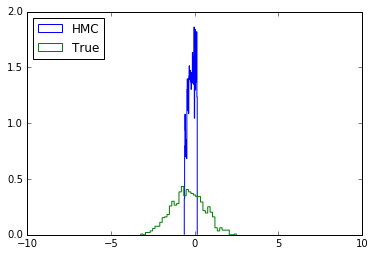

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(results[round(4*M/5):(M-1),0], 40, histtype='step', normed=True, linewidth=1, label='HMC');
plt.hist(betas, 40, histtype='step', normed=True, linewidth=1, label='True');
#plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([-10,10]);
plt.legend(loc='upper left')
pass

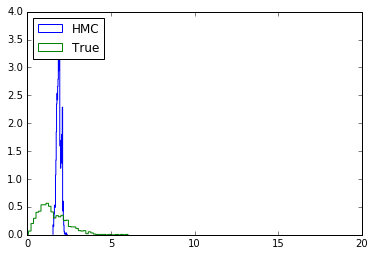

In [102]:
plt.hist(results[round(4*M/5):(M-1),1], 40, histtype='step', normed=True, linewidth=1, label='HMC');
plt.hist(phis, 40, histtype='step', normed=True, linewidth=1, label='True');
#plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([0,20]);
plt.legend(loc='upper left')
pass

In [103]:
theta0[2]*(sum(np.transpose(x).dot(y))-theta0[0:2]*sum(np.transpose(x).dot(x)))-theta0[0:2]



array([-17.8645959 ,   8.81459445])

In [102]:
(.5*n+a-1)/theta0[2]-b-.5*sum((y-x.dot(theta0[0:2]))*(y-x.dot(theta0[0:2])))

-23.833355506329806